In [1]:
import os
import re

In [2]:
DATA_DIR = os.path.join(os.path.abspath("."), "data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [3]:
train_features = [f for f in os.listdir(TRAIN_DIR) if f.endswith(".png") and not f.endswith("_GT.png")]
train_masks = [f for f in os.listdir(TRAIN_DIR) if f.endswith("_GT.png")]

print("Number of train features:", len(train_features))
print("Number of train masks:", len(train_masks))

Number of train features: 0
Number of train masks: 0


In [4]:
# dataset contains one copied sample with (copy) in name -> identify and remove
[i for i in train_features if i.split(".")[0] + "_GT.png" not in train_masks]

[]

## Organizing Directories
current structure:  `data/train` & `data/test`

split both train and test based on whether they are defective or not

i.e `data/*/defect` & `data/*/no_defect`

In [5]:
from PIL import Image
import numpy as np

In [6]:
def split_defective(dirname):
    images = [f.split(".")[0] for f in os.listdir(dirname) if f.endswith(".png") and not f.endswith("_GT.png")]
    for img in images:
        mask = np.array(Image.open(os.path.join(dirname, img + "_GT.png")))
        if mask.sum() > 0:
            os.rename(os.path.join(dirname, img + ".png"),os.path.join(dirname, "defect", img + ".png"))
            os.rename(os.path.join(dirname, img + "_GT.png"),os.path.join(dirname, "defect", img + "_GT.png"))
        else:
            os.rename(os.path.join(dirname, img + ".png"),os.path.join(dirname, "no_defect", img + ".png"))
            os.rename(os.path.join(dirname, img + "_GT.png"),os.path.join(dirname, "no_defect", img + "_GT.png"))

In [7]:
split_defective(TRAIN_DIR)

In [8]:
num_train_defect = len([f for f in os.listdir(TRAIN_DIR + "\\defect") if not f.endswith("_GT.png")])
num_train_no_defect = len([f for f in os.listdir(TRAIN_DIR + "\\no_defect") if not f.endswith("_GT.png")])

num_test_defect = len([f for f in os.listdir(TEST_DIR + "\\defect") if not f.endswith("_GT.png")])
num_test_no_defect = len([f for f in os.listdir(TEST_DIR + "\\no_defect") if not f.endswith("_GT.png")])

print("Number of defective images in TRAIN:", num_train_defect)
print("Number of non-defective images in TRAIN:", num_test_no_defect)
print("Number of defective images in TEST:", num_test_defect)
print("Number of non-defective images in TEST:", num_test_no_defect)

Number of defective images in TRAIN: 246
Number of non-defective images in TRAIN: 894
Number of defective images in TEST: 110
Number of non-defective images in TEST: 894


In [9]:
split_defective(TEST_DIR)

## Configuring Data Loading

In [10]:
import torch as t
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import matplotlib.pyplot as plt

In [11]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.classes = ["no_defect", "defect"]  # Ensures labels are assigned correctly

        self.samples = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(".png") and not img_name.endswith("_GT.png"):
                    img_path = os.path.join(class_dir, img_name)
                    mask_path = os.path.join(class_dir, img_name.replace(".png", "_GT.png"))
                    self.samples.append((img_path, mask_path, label))  # Store image, mask, and label
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, label = self.samples[idx]

        # Open images
        image = Image.open(img_path).convert("RGB")  # Feature image
        mask = Image.open(mask_path).convert("L")   # Mask (grayscale)

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label 

In [45]:
# Get Weighted Sampler to assign weights to each sample based on class frequency
def get_sampler(dataset):
    labels = [sample[2] for sample in dataset.samples]
    class_counts = np.bincount(labels)
    class_weights = 10.0 / class_counts
    
    print(class_weights)
    
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

In [46]:
get_sampler(train_dataset)

[0.00479616 0.04065041]


In [21]:
BATCH_SIZE=16

img_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    
])

mask_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = DefectDataset(TRAIN_DIR, transform=img_transform, mask_transform=mask_transform)
test_dataset = DefectDataset(TEST_DIR, transform=img_transform, mask_transform=mask_transform)

train_dataloader = DataLoader(train_dataset, sampler=get_sampler(train_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [15]:
def show_img(tensor):
    img = tensor.permute(1,2,0)
    plt.imshow(img)


## Configuring ResNet

In [16]:
import torchvision.models as models
from torch import nn

In [17]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False


c:\Users\aaadi\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aaadi\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
class DefectDetector(nn.Module):
    def __init__(self, backbone, num_classes=1, freeze_backbone=True):
        super(DefectDetector, self).__init__()
        
        self.backbone = backbone(pretrained=True)
        
        if freeze_backbone:
            for param in list(self.backbone.parameters())[:-10]:
                param.requires_grad = False
        
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

    def fit(self, dataloader, loss_fn, optimizer, epochs=50, lr=0.001):
        criterion = loss_fn()
        optim = optimizer(self.classifier.parameters(), weight_decay=1e-3, lr=lr)
        
        for epoch in range(epochs):
            self.train()
            total_loss = 0

            for images, masks, labels in dataloader:
                images, labels = images.to(device), labels.float().to(device)
                
                optim.zero_grad()
                outputs = self.forward(images).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optim.step()

                total_loss += loss.item()
            print(f"Epoch [{epoch + 1}/{epochs}]")
            print(f"Loss: {total_loss / len(train_dataloader):.6f}")



In [41]:
model = DefectDetector(backbone=models.resnet50).to(device)
model

c:\Users\aaadi\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aaadi\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DefectDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [42]:
loss_fn = t.nn.BCELoss
optim = t.optim.AdamW
model.fit(train_dataloader, loss_fn, optim, epochs=50, lr=0.0004)

Epoch [1/50]
Loss: 0.616858
Epoch [2/50]
Loss: 0.557212
Epoch [3/50]
Loss: 0.547285
Epoch [4/50]
Loss: 0.531708
Epoch [5/50]
Loss: 0.525891
Epoch [6/50]
Loss: 0.524633
Epoch [7/50]
Loss: 0.512431
Epoch [8/50]
Loss: 0.520627
Epoch [9/50]
Loss: 0.521685
Epoch [10/50]
Loss: 0.511092
Epoch [11/50]
Loss: 0.509294
Epoch [12/50]
Loss: 0.502378
Epoch [13/50]
Loss: 0.517523
Epoch [14/50]
Loss: 0.518013
Epoch [15/50]
Loss: 0.508759
Epoch [16/50]
Loss: 0.505923
Epoch [17/50]
Loss: 0.506705
Epoch [18/50]
Loss: 0.516043
Epoch [19/50]
Loss: 0.505999
Epoch [20/50]
Loss: 0.531183
Epoch [21/50]
Loss: 0.512016
Epoch [22/50]
Loss: 0.486920
Epoch [23/50]
Loss: 0.502113
Epoch [24/50]
Loss: 0.498745
Epoch [25/50]
Loss: 0.486511
Epoch [26/50]
Loss: 0.497793
Epoch [27/50]
Loss: 0.510043
Epoch [28/50]
Loss: 0.496641
Epoch [29/50]
Loss: 0.497239
Epoch [30/50]
Loss: 0.486335
Epoch [31/50]
Loss: 0.495226
Epoch [32/50]
Loss: 0.499590
Epoch [33/50]
Loss: 0.507275
Epoch [34/50]
Loss: 0.504616


KeyboardInterrupt: 

In [38]:
model.eval()


DefectDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [160]:
sample = next(iter(train_dataloader))

In [161]:
predictions = model.forward(sample[0][:25].to(device)).round()
predictions

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [162]:
(predictions[0] == sample[2][:25].to(device)).int()

tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def evaluate(model, test_dataloader, verbose=False):
    all_labels = []
    all_preds = []

    model.eval()
    with t.no_grad():
        for images, masks, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).round()
            preds = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

            # Compute metrics for each batch
            acc = accuracy_score(labels, preds)
            if verbose:
                print(f"Batch Accuracy: {acc:.4f}")
                print(classification_report(labels, preds))
                cm = confusion_matrix(labels, preds)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot()
                plt.show()

    # Compute metrics for all data combined
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    overall_acc = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {overall_acc:.4f}")
    print(classification_report(all_labels, all_preds))
    overall_cm = confusion_matrix(all_labels, all_preds)
    overall_disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm)
    overall_disp.plot()
    plt.show()

Overall Accuracy: 0.7819
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       894
           1       0.26      0.55      0.35       110

    accuracy                           0.78      1004
   macro avg       0.60      0.68      0.61      1004
weighted avg       0.86      0.78      0.81      1004



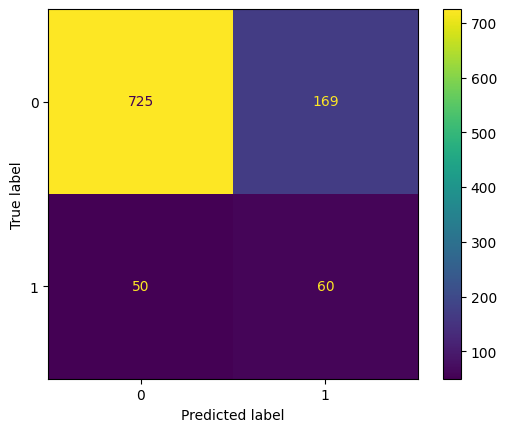

In [39]:
evaluate(model, test_dataloader)